In [13]:
import os
import numpy as np
from load_data import *
from sklearn.model_selection import train_test_split
import torch
from torch.nn import *
from models import *
from training import *
from torch.utils.data import *
import matplotlib.pyplot as plt
import time

In [14]:
# Set torch seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Load data

In [15]:
params, solutions, basis_space, basis_time, sv_space, sv_time = load_data()

# Upper and lower bound of params
upper_bounds_params = np.array([8.0, 0.3, 0.5, 0.5, 0.5, 0.0])
lower_bounds_params = np.array([4.0, 0.1, -0.1, -0.5, -0.5, -0.3])

# Params mapping to [0, 1]
params = (params - lower_bounds_params) / (upper_bounds_params - lower_bounds_params)

# Split training and test set

In [16]:
# Splitting train-test

split = 0.9

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(params, solutions['velocity'], test_size=1-split, random_state=0)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(params, solutions['pressure'], test_size=1-split, random_state=0)

# Create Dataset class

In [17]:
# Class for a dataset structure

class CreateDataset(Dataset):

    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y.reshape(x.shape[0], -1), dtype = torch.float32)  # unique tensor for space and time

    def __getitem__(self,index):
        sample = {
            'feature': self.x[index],
            'label': self.y[index]}
        return sample

    def __len__(self):
        return len(self.x)

# Train the final models

In [18]:
# Parameters

# Set device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Number of neurons per layer
K = 256

# Learning rate
lr = 0.01

# Number of epochs
num_epochs = 500

# K-fold
folds = 5

# Batch size
batch_size = 32

Train epoch 1: loss = 37.89046554353502, error = 0.688709145784378, lr = 0.0099
Train epoch 101: loss = 0.6184854602813721, error = 0.06451061291827095, lr = 0.003148091731809522
Train epoch 201: loss = 0.022968268800112938, error = 0.016569786287016337, lr = 0.001001058742614896
Train epoch 301: loss = 0.015430985556708441, error = 0.013711887382798724, lr = 0.00031832573239207976
Train epoch 401: loss = 0.013212245677908262, error = 0.012706392324633069, lr = 0.00010122410163290076


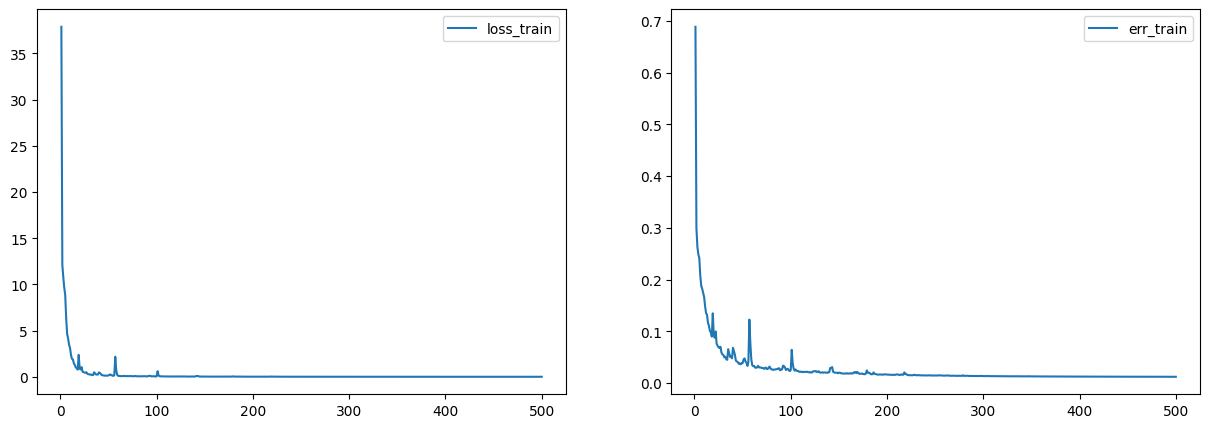

Execution time: 86s


In [19]:
# Train the final model for velocity

train = CreateDataset(x_train_v, y_train_v)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_v = PTCMapVelocity(K, 40, 37)

start = time.time()

run_training(train_gen, None, num_epochs, model_v, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

Train epoch 1: loss = 171.14091668023002, error = 0.6890988938013712, lr = 0.0099
Train epoch 101: loss = 0.17753662122620475, error = 0.021268049991793103, lr = 0.003148091731809522
Train epoch 201: loss = 0.08346123518215286, error = 0.014983300376269552, lr = 0.001001058742614896
Train epoch 301: loss = 0.04940357699990273, error = 0.011734200227591727, lr = 0.00031832573239207976
Train epoch 401: loss = 0.04215094392498334, error = 0.010861164505283037, lr = 0.00010122410163290076


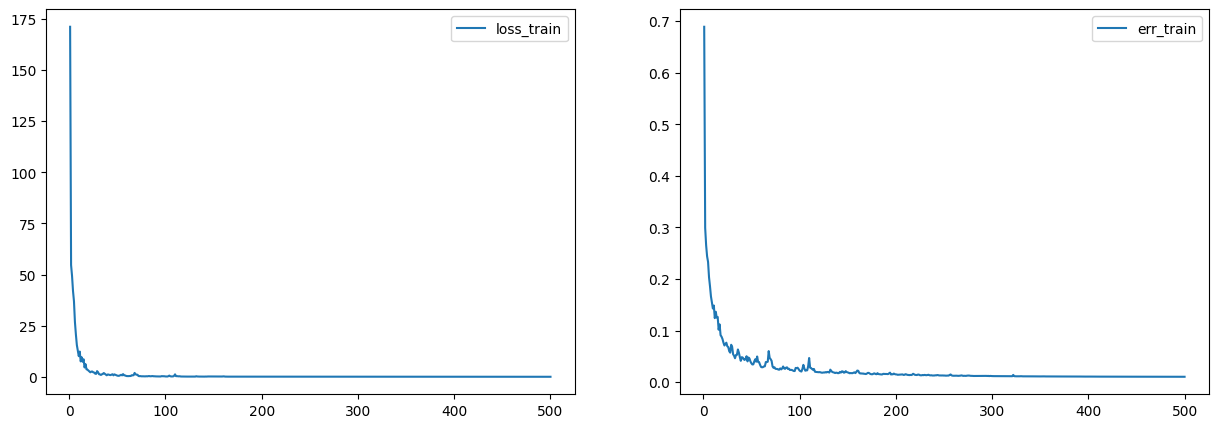

Execution time: 82s


In [20]:
# Train the final model for pressure

train = CreateDataset(x_train_p, y_train_p)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_p = PTCMapPressure(K, 7, 47)

start = time.time()

run_training(train_gen, None, num_epochs, model_p, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

# Test the final models

In [21]:
# Creating pressure and velocity test datasets

test_v = CreateDataset(x_test_v, y_test_v)
test_p = CreateDataset(x_test_p, y_test_p)

In [22]:
# Test data generators

test_v_gen = DataLoader(test_v, batch_size=len(test_v))
test_p_gen = DataLoader(test_p, batch_size=len(test_p))

In [23]:
# Compute test error

test_error_v = compute_error(model_v, test_v_gen, device)
print('Velocity test error: {:.2f}%'.format(test_error_v * 100))
test_error_p = compute_error(model_p, test_p_gen, device)
print('Pressure test error: {:.2f}%'.format(test_error_p * 100))

Velocity test error: 1.61%
Pressure test error: 1.38%


# Expand and visualize solutions

In [26]:
# Compute predictions

predictions_v = predict(model_v, test_v_gen, device).to('cpu').detach().numpy()
predictions_p = predict(model_p, test_p_gen, device).to('cpu').detach().numpy()

In [40]:
# Plot solutions vs predictions for the snapshot at idx

idx = 0

predictions_v_idx = predictions_v[idx].reshape((40,37))
predictions_v_ex = expand(predictions_v_idx, basis_space['velocity'], basis_time['velocity'])
solutions_v_ex = expand(y_test_v[idx], basis_space['velocity'], basis_time['velocity'])
predictions_p_idx = predictions_p[idx].reshape((7,47))
predictions_p_ex = expand(predictions_p_idx, basis_space['pressure'], basis_time['pressure'])
solutions_p_ex = expand(y_test_p[idx], basis_space['pressure'], basis_time['pressure'])
norm_solutions_v = np.linalg.norm(solutions_v_ex, axis=0)
norm_predictions_v = np.linalg.norm(predictions_v_ex, axis=0)
norm_solutions_p = np.linalg.norm(solutions_p_ex, axis=0)
norm_predictions_p = np.linalg.norm(predictions_p_ex, axis=0)

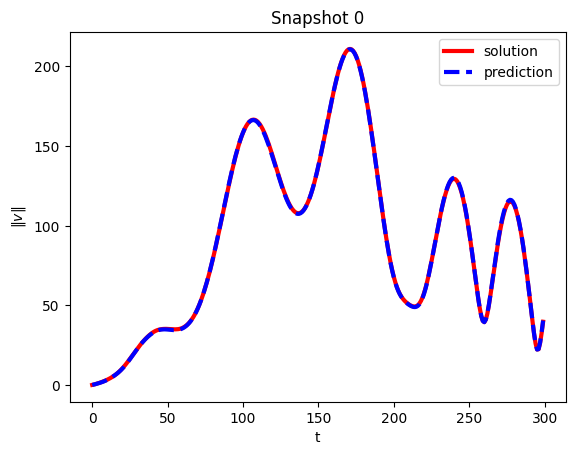

In [41]:
plt.plot(norm_solutions_v, color = 'r', linewidth='3')
plt.plot(norm_predictions_v, linestyle = '--', color = 'b', linewidth='3')
plt.xlabel('t')
plt.ylabel('$\|v\|$')
plt.legend(['solution', 'prediction'])
plt.title('Snapshot {}'.format(idx))
plt.show()

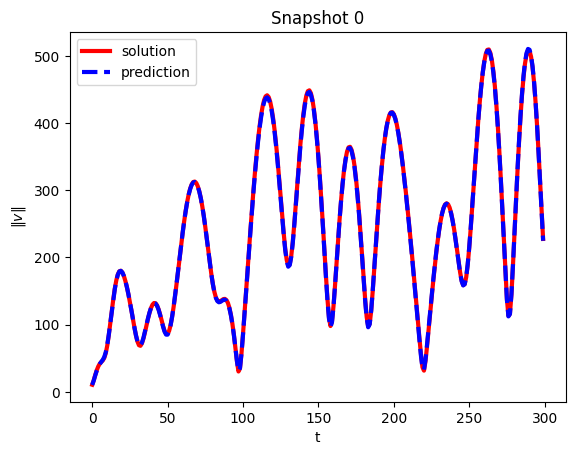

In [42]:
plt.plot(norm_solutions_p, color = 'r', linewidth='3')
plt.plot(norm_predictions_p, linestyle = '--', color = 'b', linewidth='3')
plt.xlabel('t')
plt.ylabel('$\|v\|$')
plt.legend(['solution', 'prediction'])
plt.title('Snapshot {}'.format(idx))
plt.show()